In [1]:
import sys
sys.path.append("..")
import os
os.chdir("..")
import comet_ml
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import torch
from monai.transforms import (
    Compose,
    LoadImage,
    Orientation,
    CropForeground,
    Resize,
    ScaleIntensity,
    Transform,
    SpatialPad
)
from monai.data import CacheDataset, DataLoader, ZipDataset

from neuro_ix.datasets.mriqc_dataset import MIDLAMPSCZDataset
from neuro_ix.datasets.neuro_ix_dataset import MRIModality
api = comet_ml.API(
            api_key="WmA69YL7Rj2AfKqwILBjhJM3k"
        )
def threshold_one(x):
    return x >= 0.01

/opt/anaconda/envs/bowl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get Dataset

In [20]:
imshape = (1, 160, 192, 160)
ds = MIDLAMPSCZDataset.lab()
test_path= ds.get_images_path(MRIModality.T1w)
test_scores = list(map(lambda x: int(ds.motion_label(x)), test_path))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
transform = Compose(
            [
                LoadImage(ensure_channel_first=True, image_only=True),
                Orientation(axcodes="RAS"),
                ScaleIntensity(0, 1),
                CropForeground(threshold_one, allow_smaller=True),
                Resize(( 160, 192, 160)),
            ]
        )
#val_ds = CacheDataset(data=test_path, transform=transform, num_workers=10)
val_loader = DataLoader(ZipDataset([val_ds, test_scores]), batch_size=20)
len(test_scores)

758

In [12]:
test_scores

[1,
 2,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,


## Get Models

In [3]:
from neuro_ix.models.baseline import BaselineModel
from neuro_ix.models.rnn_cnn import RNNCNN
from neuro_ix.models.augmented_cnn import AugBaselineModel
from neuro_ix.models.naive_res import RNNCNN as NaiveRNN
from sklearn.metrics import accuracy_score, confusion_matrix
from neuro_ix.utils.score import analyse_classif
import glob


In [4]:
experiments = api.get("cbricout", "midl2024")
experiments

[<APIExperiment 'cbricout/midl2024/f83fdb62cfea4946b01e4aec7a8d3014'>,
 <APIExperiment 'cbricout/midl2024/b128ba24c69743168641d05f2f858c41'>,
 <APIExperiment 'cbricout/midl2024/bcc6dab39fae484294ba399e2becb2d5'>,
 <APIExperiment 'cbricout/midl2024/9c0b75eca72640c38ba29ee97c47cff1'>,
 <APIExperiment 'cbricout/midl2024/66e77cce966c48229218514016beb4f8'>,
 <APIExperiment 'cbricout/midl2024/577b5388ef1e4806a11af9ff8a79ce52'>,
 <APIExperiment 'cbricout/midl2024/cbca38a0a8274bdcaf8b44aa7f0819f9'>,
 <APIExperiment 'cbricout/midl2024/66828e809d454272b3c361b93440ce44'>,
 <APIExperiment 'cbricout/midl2024/d4ebdff182a648a5b283c95ecb0a44e5'>,
 <APIExperiment 'cbricout/midl2024/cef004164ebd4effa88c5bff5790da28'>,
 <APIExperiment 'cbricout/midl2024/9ec3e77a9a4342d19fd7fc0e21e8afdc'>,
 <APIExperiment 'cbricout/midl2024/f3df7a60b90f40e684627f69924fb31c'>,
 <APIExperiment 'cbricout/midl2024/37253dd1673645faa894416bd32da127'>,
 <APIExperiment 'cbricout/midl2024/d7c30dd23d0c4e9da9867ab94fb56e07'>,
 <APIE

In [27]:
def test_exp(exp:comet_ml.APIExperiment):
    plt.clf()
    mod_name=exp.get_model_names()[0]

    exp.download_model(mod_name, output_path="current-amp")
    use_dec = not "NoDec" in mod_name
    if "Baseline" in mod_name:
        model = BaselineModel(1,imshape, use_decoder=use_dec)
    elif 'Augmented' in mod_name:
        model = AugBaselineModel(1, imshape, use_decoder=use_dec)
    elif 'RNN' in mod_name:
        model = RNNCNN(1, imshape, use_decoder=use_dec)
    elif 'NaiveRes' in mod_name:
        model = NaiveRNN(1, imshape, use_decoder=use_dec)
    model.load_state_dict(torch.load("current-amp/model-data/comet-torch-model.pth"))
    model.to(device)
    model.eval()
    pred=[]
    label=[]
    with torch.no_grad():
        for x,y in val_loader:
            x=x.to(device)
            _,_, classe=model(x)
            pred+=(classe.argmax(dim=1)>1).cpu().tolist()
            label+=y.tolist()
    
    accs = analyse_classif(label, pred)
    run_num = len(glob.glob(f'ampscz_fig/{mod_name}-conf*'))
    plt.tight_layout()
    plt.savefig(f'ampscz_fig/{mod_name}-conf-{run_num+1}')
    print(pred, label)
    return (f"{mod_name}", run_num+1, accuracy_score(label, pred), *accs)

COMET INFO: Downloading experiment model 'Baseline-NoDec' ...
COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...


[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, Tru

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline-NoDec' ...


[True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, False, True, True, False, True, True, False, True, True, True, True, False, False, True, True, True, True, True, True, True, False, False, True, False, False, False, False, False, True, False, True, True, False, True, False, True, False, True, True, False, True, False, True, True, False, True, True, True, True, False, False, False, False, False, False, False, False, False, True, True, True, True, True, False, True, True, True, True, False, True, True, False, False, False, False, True, False, False, True, True, False, False, True, False, True, True, True, True, True, False, False, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, False, True, True, False, True, True, True, True, True, True, True, True, False, False, False, True, True, False, True, True, True, False, True, True, True, True, False, True, False, True, True, True, True, False, False, True, 

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline-NoDec' ...


[True, True, True, False, True, True, False, False, True, True, True, True, False, True, True, True, False, True, False, True, True, False, False, True, True, False, False, False, True, True, False, True, True, True, False, False, False, True, False, True, False, False, False, False, False, False, False, False, True, False, True, False, True, False, False, True, False, True, True, False, False, False, True, True, False, False, False, False, False, False, False, False, False, True, True, False, False, True, False, False, True, True, False, False, True, True, False, False, False, False, True, False, True, True, True, False, False, True, False, True, True, True, True, False, False, False, True, True, True, True, True, True, False, True, True, True, True, True, True, False, False, False, True, True, False, False, True, False, True, True, True, True, True, False, False, False, True, True, False, True, True, True, False, False, True, False, False, False, True, False, True, True, True, True, 

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline-NoDec' ...


[True, True, True, False, False, True, False, False, False, False, True, True, False, True, True, True, False, False, False, True, True, False, True, True, True, True, False, False, True, True, False, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, True, True, True, False, True, False, True, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, False, False, False, True, True, False, False, False, False, False, False, False, True, False, False, False, True, False, True, True, True, True, False, False, False, False, True, True, False, True, True, False, True, True, False, True, True, True, False, True, False, True, True, False, True, True, True, True, True, True, False, True, False, False, False, True, True, False, True, True, False, False, False, False, False, False, False, True, False, True, True, T

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...


[True, True, True, False, True, True, False, True, False, False, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, False, True, False, True, False, False, True, False, True, True, True, False, True, False, True, False, False, False, False, False, True, True, False, True, False, True, False, True, True, False, True, False, True, True, False, False, True, True, False, True, False, False, False, False, False, False, False, False, True, True, False, True, True, False, False, True, True, False, False, True, True, False, False, True, False, False, False, True, True, True, False, False, True, True, True, True, True, True, True, False, False, True, True, True, True, True, False, False, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, True, True, True, False, False, True, True, True, True, True, False, True, True, True, True, False, False, True, True, False, True, False, True, True, True, True, True, True, True

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...


[True, True, True, False, True, True, False, False, False, False, True, True, False, True, True, True, False, False, False, False, True, False, False, True, True, False, False, False, True, False, False, True, False, True, True, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, True, True, True, True, False, True, False, True, True, True, True, False, True, True, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, True, False, False, True, True, False, False, False, False, False, False, False, True, True, False, True, False, False, True, True, True, False, False, False, False, True, False, True, True, True, True, False, False, True, True, True, True, True, False, True, False, True, True, False, False, True, True, True, False, True, False, True, False, False, False, True, True, False, True, True, True, False, False, False, True, False, False, True, False, False, True, Tru

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline-NoDec' ...


[True, True, True, False, False, True, False, True, False, False, True, True, False, False, False, False, False, False, False, False, True, False, True, True, True, False, False, False, True, False, False, True, False, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, True, False, False, False, False, True, False, True, True, False, False, False, True, True, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, True, False, False, True, True, False, False, False, False, True, False, False, True, True, False, False, True, False, False, True, True, True, False, False, False, True, False, True, False, False, True, False, False, True, False, False, True, True, False, False, False, True, False, False, False, True, False, True, False, False, True, True, False, False, False, True, True, False, False, True, True, False, False, False, False, False, False, True, False, 

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...


[True, True, True, False, True, True, False, True, False, False, True, True, False, False, True, True, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, True, False, False, True, True, True, True, False, False, False, True, True, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, True, True, True, True, False, False, False, False, False, False, False, False, True, False, True, True, True, True, True, True, False, True, False, True, True, False, True, True, True, True, True, True, False, True, False, False, False, True, True, False, False, True, True, False, False, False, False, False, False, True, False, Tru

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Baseline' ...


[True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, False, False, True, True, False, True, True, True, False, False, False, True, False, False, False, False, False, True, False, True, False, False, True, False, True, True, True, True, True, True, False, True, True, False, False, False, True, True, True, False, False, False, False, False, False, False, False, True, True, False, False, False, True, True, True, True, False, False, True, True, False, False, False, False, False, False, False, True, True, False, False, True, False, True, True, True, True, True, False, False, False, False, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, False, True, True, True, True, True, True, True, True, False, True, False, True, True, True, True, False, True, True, T

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes-NoDec' ...


[True, True, True, False, True, True, False, False, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, False, True, True, False, True, True, True, True, False, False, True, False, True, False, False, False, False, False, True, True, False, True, False, True, False, False, False, False, True, False, True, True, False, False, False, True, True, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, True, True, True, False, False, True, True, False, False, False, False, True, False, True, True, True, False, False, True, False, False, True, True, True, True, False, False, True, True, True, True, True, True, False, True, True, True, True, True, True, False, True, False, True, True, False, False, True, True, True, True, True, True, True, False, False, False, True, True, False, False, True, True, False, False, False, True, False, False, True, False, True, True, True, True, True, Tr

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented-NoDec' ...


[True, True, True, False, True, True, False, False, False, True, True, True, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, False, True, False, True, True, False, False, True, False, True, False, False, False, True, True, True, True, False, True, False, True, True, True, True, False, True, False, True, True, True, False, True, True, True, True, False, False, False, False, True, False, True, False, True, True, True, True, True, False, False, True, True, True, False, True, True, True, False, True, False, True, False, True, True, True, False, True, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, False, True, False, False, False, True, True, False, False, False, True, False, False, False, True, True, False, True, False, True, True, True, True, True, False, True, True, F

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes-NoDec' ...


[True, True, True, False, True, True, False, False, False, True, True, True, False, True, True, False, False, True, False, True, True, False, False, True, True, False, False, False, True, False, False, True, False, True, True, False, False, True, False, True, False, False, False, True, False, False, False, False, True, False, False, False, True, False, False, True, False, True, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, True, False, False, True, True, False, False, False, False, False, False, False, True, False, False, False, False, False, True, True, True, True, False, False, False, True, True, True, False, False, True, False, True, True, False, True, True, True, False, False, False, True, False, False, False, True, False, True, False, False, False, False, False, False, False, True, True, False, False, True, True, False, False, False, False, False, False, True, False, True,

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN-NoDec' ...


[True, True, True, False, True, True, False, True, False, False, True, True, False, True, True, True, False, True, False, False, True, False, True, True, True, False, False, False, True, False, False, True, False, True, True, False, False, True, False, False, False, False, False, True, False, False, False, False, True, False, True, False, True, False, False, True, False, True, True, False, False, False, True, True, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, True, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, False, False, False, True, True, True, True, False, True, False, True, True, False, False, True, True, False, False, False, True, True, False, False, True, False, True, False, False, True, False, False, False, False, True, True, False, False, False, True, False, False, False, False, False, False, True, False, True, 

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...


[True, True, False, False, True, False, False, False, True, False, False, True, False, True, False, False, True, True, False, False, False, True, False, True, True, False, True, False, True, True, True, True, False, True, False, False, True, True, True, True, False, True, False, True, True, True, True, False, True, False, True, False, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, True, True, True, False, False, False, False, True, True, True, False, True, True, False, False, True, False, True, True, True, True, True, False, True, True, False, True, True, True, True, False, False, False, False, True, True, True, False, False, False, False, True, True, True, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False, False, False, False, False, True, False, True, False, False, True, False, False, True,

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...


[True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, False, True, False, False, False, True, False, True, True, True, False, False, False, True, False, False, True, True, True, False, False, False, True, False, True, False, False, False, True, False, False, True, False, True, False, True, True, True, False, False, True, False, True, True, False, False, False, True, True, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, True, False, False, True, True, False, False, False, False, True, False, False, True, False, False, False, True, False, True, True, True, True, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, False, True, False, True, False, False, True, True, False, False, False, True, True, False, True, True, True, False, False, True, True, False, False, True, False, True, True, True, True, Fa

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented-NoDec' ...


[True, True, True, False, True, True, False, False, False, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, False, False, True, True, False, True, False, True, True, False, False, True, False, True, False, False, False, True, False, True, False, False, True, False, True, True, True, True, False, True, False, True, True, True, True, False, True, True, True, False, False, False, False, False, False, True, False, True, True, False, True, True, False, False, True, True, False, False, True, True, False, False, False, False, True, False, False, True, False, False, False, True, True, True, True, True, True, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, False, True, True, True, True, True, False, True, False, False, True, False, True, True, True, True, True, True, False, T

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented-NoDec' ...


[True, True, True, False, True, True, False, False, False, True, True, True, False, True, True, True, False, False, False, True, True, False, False, True, False, False, False, False, True, True, False, True, False, True, False, False, False, True, False, True, False, False, False, True, False, True, False, False, True, False, True, False, True, True, False, True, False, True, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, True, True, True, False, False, True, True, False, False, False, False, True, False, False, False, False, False, False, False, False, True, True, True, True, False, False, False, True, True, False, False, False, True, False, True, True, False, False, True, True, False, False, False, True, True, False, False, True, True, True, False, True, True, False, False, False, False, True, True, False, True, True, True, True, False, False, True, False, False, True, False, True, True, T

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...


[True, True, True, False, True, True, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, True, False, False, True, True, False, True, True, True, True, True, False, True, False, True, False, False, False, True, True, True, True, False, True, False, False, True, True, True, False, True, True, True, True, False, False, False, True, False, False, False, False, False, False, True, False, False, False, True, True, True, True, True, False, True, True, True, True, False, True, True, False, False, True, False, False, True, True, True, True, False, False, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, False, True, True, True, True, True, True, False, True, False, True, True, False, True, True, True, True, True, True, False, False, True, True, False, True, True, True, False, True, True, True, False, False, True, True, False, True, False, True, True, True, True, True, True, True, True,

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN-NoDec' ...


[True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, False, False, False, True, True, False, True, True, True, True, False, False, True, False, True, False, False, False, True, True, True, True, False, True, False, True, True, True, True, False, True, False, True, True, False, False, True, True, True, True, False, False, False, False, False, False, False, False, True, True, True, True, True, False, True, True, True, True, False, True, True, False, False, True, False, True, False, True, True, True, False, False, True, False, True, True, True, True, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, False, False, True, True, False, True, True, True, True, True, True, True, False, False, True, False, True, True, True, True, False, True, True, True, True

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented-NoDec' ...


[True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, False, True, True, True, True, False, False, True, True, False, True, True, True, True, True, False, True, False, True, False, False, False, True, False, True, True, False, True, False, True, True, True, False, False, True, True, True, True, True, True, True, True, True, False, False, False, False, False, True, False, False, False, True, True, False, False, False, False, True, True, True, False, False, True, True, True, True, True, False, True, False, False, True, True, False, False, False, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, True, Fa

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...


[True, True, True, True, True, True, False, False, False, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, False, False, True, False, True, False, False, False, True, False, True, True, False, True, False, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, False, False, False, False, False, False, False, False, True, True, False, True, True, False, True, True, True, False, False, True, True, True, True, False, False, True, False, False, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, False, False, True, True, False, True, False, False, True, True, True, True, True, True, True, True, Fal

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes-NoDec' ...


[True, True, True, False, True, True, False, True, False, True, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, False, False, True, True, False, True, True, True, True, False, False, True, False, True, False, False, False, True, False, True, True, False, True, False, True, True, True, True, False, True, True, True, True, True, True, False, True, True, True, False, False, False, False, False, False, True, False, True, True, True, True, True, False, True, True, True, True, False, True, True, False, True, False, False, True, False, False, True, True, False, False, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, False, False, True, True, False, True, True, True, True, True, False, True, False, False, True, False, True, True, True, True, True, True, True, True, True,

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...


[True, True, True, False, True, True, False, True, True, True, True, True, False, True, True, True, False, True, False, True, True, False, True, True, True, False, False, False, True, True, False, True, True, True, True, False, False, True, False, False, False, False, False, True, False, True, False, False, True, False, True, True, True, False, False, True, False, True, True, False, True, False, True, True, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, True, False, False, True, True, False, False, False, False, False, False, False, True, True, False, False, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True, False, True, True, True, True, True, True, True, False, False, False, True, True, False, True, True, True, False, False, True, False, False, False, True, False, True, True, True, True, True, Tru

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN-NoDec' ...


[True, True, True, False, True, True, False, True, True, True, True, True, False, True, True, True, False, True, False, True, True, False, True, True, True, False, False, False, True, False, False, True, True, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, True, True, True, False, False, True, False, True, True, False, False, True, True, True, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, True, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True, True, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, False, True, False, True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, False, False, False, True, False, True, True, True, True, False

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...


[True, True, True, True, True, True, False, False, False, True, True, True, True, True, True, True, False, False, False, True, True, True, False, True, True, True, False, False, True, True, False, True, True, True, True, False, False, True, False, True, False, True, False, False, False, True, True, True, True, False, True, True, True, True, False, False, True, True, True, True, True, False, True, False, True, False, False, False, False, True, False, False, False, True, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, False, False, True, True, True, True, True, True, False, False, True, True, True, True, True, False, False, True, True, False, False, True, True, False, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, False, True, True, True, True, False, False, True, True, False, True, False, False, True, True, True, True, True, True, False, T

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...


[True, True, True, False, True, True, False, True, False, True, True, True, False, True, True, True, False, False, False, False, True, False, True, True, True, False, False, False, True, True, False, True, True, True, True, False, False, True, False, True, False, False, False, False, False, False, False, False, True, False, True, True, True, False, False, True, False, True, True, False, False, False, True, True, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, True, True, False, False, False, True, True, False, False, False, False, False, False, False, False, True, False, False, False, False, True, True, True, True, False, False, False, True, True, True, True, True, False, True, True, True, False, True, True, True, False, True, False, True, True, True, False, True, False, True, True, True, True, True, True, False, False, True, True, False, True, True, True, False, False, True, True, True, False, True, False, True, True, True, True, 

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes-NoDec' ...


[True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, False, False, False, True, True, False, True, True, True, True, False, False, True, False, True, False, False, False, True, False, True, True, False, True, False, True, True, True, True, False, True, False, True, True, False, True, True, True, True, True, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, True, False, False, True, True, False, False, True, False, True, False, True, True, True, False, False, True, True, True, True, True, True, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, False, False, True, True, False, True, True, True, False, True, True, True, False, False, True, False, True, True, True, True, True, True, True, True,

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented' ...


[True, True, True, False, True, True, False, False, False, False, True, True, False, True, True, True, False, False, False, False, True, False, False, False, True, True, False, False, True, False, False, True, False, True, True, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, True, False, True, False, False, True, False, True, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, True, False, False, True, True, False, False, False, False, False, False, False, True, False, False, False, False, False, True, True, True, True, False, False, False, True, True, True, True, True, True, False, True, True, False, False, True, True, False, False, False, True, False, False, False, True, True, True, True, True, False, False, False, False, False, True, True, False, False, True, True, False, False, False, True, False, False, True, False, False, 

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'Augmented-NoDec' ...


[True, True, True, False, True, True, False, True, False, True, True, True, False, True, True, True, False, True, False, False, True, False, True, True, True, False, False, False, True, True, False, True, True, True, True, False, False, True, False, False, False, False, False, True, False, True, True, False, True, False, True, True, True, False, False, True, False, True, True, False, True, True, True, True, True, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, True, False, False, True, True, False, False, False, False, True, False, False, False, False, False, False, False, False, True, True, True, True, False, False, False, True, True, True, False, True, True, True, True, True, True, True, True, True, False, True, False, True, True, False, False, True, False, True, True, True, True, True, True, True, False, True, True, False, False, True, True, False, False, False, True, False, False, True, False, True, True, True, True, Fals

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN-NoDec' ...


[True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, True, False, True, False, True, True, True, True, True, True, False, False, False, True, True, False, True, True, True, True, False, False, True, False, True, False, False, False, True, False, True, True, False, True, False, True, True, True, True, True, True, False, True, True, False, False, False, True, True, True, False, False, False, False, False, False, False, False, True, True, False, False, True, False, True, True, True, False, False, True, True, True, False, False, False, True, False, False, True, True, False, True, True, False, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, True, False, True, True, False, False, False, False, True, True, False, True, True, True, False, True, True, True, True, False, True, False, True, True, True, True, True, True, True, Tru

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN-NoDec' ...


[True, True, True, False, True, True, False, False, False, False, True, True, False, True, True, True, False, False, False, True, True, True, False, False, False, False, True, True, True, False, False, True, True, True, True, False, False, True, True, True, False, True, False, True, True, True, True, True, True, False, True, True, True, True, False, True, False, True, True, True, False, False, True, False, True, False, False, False, False, False, False, False, False, True, True, False, False, True, False, True, True, True, False, False, True, True, False, True, True, False, True, False, False, True, True, True, True, True, False, True, True, True, True, True, True, False, True, True, False, False, True, True, False, True, True, False, True, True, True, False, False, False, True, True, False, False, True, False, True, False, False, False, False, False, False, False, True, True, False, True, True, True, True, False, True, True, False, False, True, False, True, True, True, True, False, Fa

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...


[True, True, True, False, True, True, False, False, False, False, True, True, True, True, True, True, False, False, False, True, True, False, False, True, True, False, False, False, True, True, False, True, True, True, True, False, False, True, False, True, False, False, False, False, False, True, True, True, True, False, True, True, True, True, False, True, True, True, True, True, True, False, True, True, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, True, True, True, False, False, True, True, True, True, False, False, True, False, False, False, True, False, True, False, False, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, False, True, True, True, True, True, False, False, False, True, True, False, True, True, True, True, True, True, True, True, False, True, False, False, True, True, True, True, True, Tru

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'NaiveRes' ...


[True, True, True, False, True, True, False, False, False, True, True, True, False, True, True, True, False, True, False, False, True, False, True, True, True, False, False, False, True, True, False, True, True, True, True, False, False, True, False, False, False, False, False, True, False, True, True, False, True, False, True, True, True, False, False, True, False, True, True, False, False, False, True, True, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, True, False, False, True, True, False, False, False, False, True, False, False, True, True, False, False, False, False, True, True, True, True, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True, False, True, False, True, True, True, True, True, False, False, False, True, True, False, False, True, True, False, False, True, True, True, False, True, False, True, True, True, True, Fals

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450


COMET INFO: Downloading experiment model 'RNN' ...


[True, True, True, False, True, True, False, False, False, False, True, True, False, True, True, True, False, False, False, True, True, False, False, True, False, False, False, False, True, False, False, True, True, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, True, True, False, False, False, False, True, True, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, True, True, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, False, False, False, False, False, True, True, True, True, False, True, True, False, False, True, True, False, False, False, True, True, False, False, True, False, True, False, False, False, False, False, False, False, True, True, False, False, True, False, False, False, False, True, False, False, True, False,

COMET INFO: Unzipping model to 'current-amp' ...
COMET INFO: done!


450
[True, True, True, False, True, True, False, False, True, False, True, True, False, True, True, True, False, False, False, False, True, False, True, True, False, False, False, False, True, True, False, True, False, True, False, False, False, True, False, True, False, True, False, True, False, True, True, False, True, False, True, True, True, True, False, True, False, False, True, True, False, False, False, True, True, False, False, False, False, False, False, False, False, True, True, False, True, True, False, False, True, True, False, False, True, True, True, True, False, False, True, False, False, False, True, False, True, False, False, True, True, True, True, False, False, False, False, False, True, False, False, False, False, True, True, True, True, True, True, False, False, False, True, True, True, False, True, False, False, False, False, False, False, False, False, False, True, True, False, False, True, True, False, False, True, False, False, False, True, False, True, True, T

ValueError: 6 columns passed, passed data had 5 columns

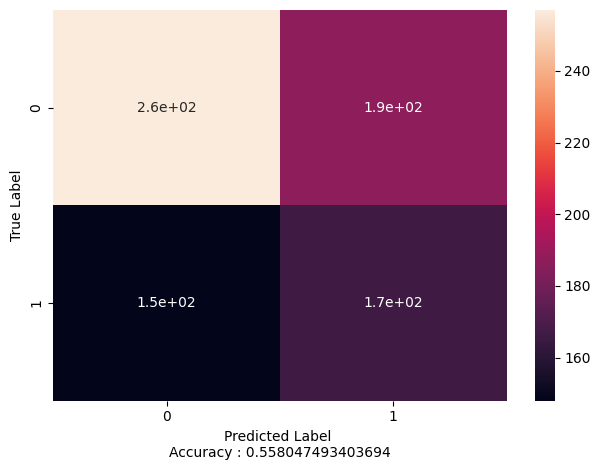

In [28]:
test_accs = []
for expm in experiments:
    test_accs.append(test_exp(expm))
res_df = pd.DataFrame(test_accs, columns=['model', 'sit', 'accuracy', 'acc1', 'acc2', 'acc3'])

In [ ]:
res_df.sort_values(['model', 'sit'])

,model,sit,accuracy
6,Augmented,1,0.404494
14,Augmented,2,0.404494
20,Augmented,3,0.606742
23,Augmented,4,0.662921
33,Augmented,5,0.640449
16,Augmented-NoDec,1,0.685393
21,Augmented-NoDec,2,0.651685
22,Augmented-NoDec,3,0.584270
25,Augmented-NoDec,4,0.584270
34,Augmented-NoDec,5,0.595506


In [26]:
res_df.groupby(by="model").agg( {'accuracy':['mean','std','median', 'max']})

NameError: name 'res_df' is not defined

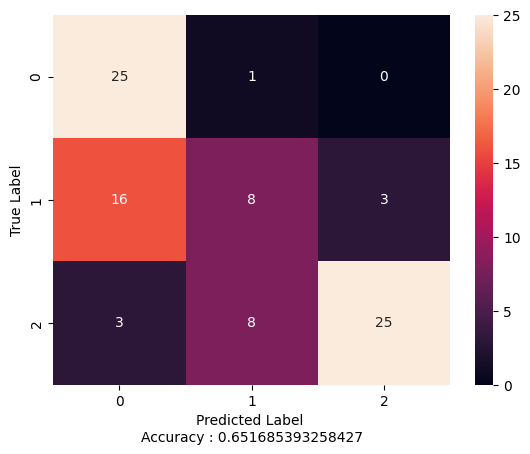

In [ ]:
analyse_classif(label, pred)